# Project Carbon Stars

In [1]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

# 1. Introduction

Stars are responsible for the production of all elements heavier than Helium. They can have different masses and chemical composition. Precise measurements of the chemical composition of stars provides us with information regarding the chemical evolution of our Galaxy. To get an estimation of the abundance of a particular element, e.g. Iron, it is necessary that the star is observed in High-resolution.  

In order to get observations in High-resolution, a large telescope is required. The Figure below shows four 8.2 m telescopes located in Chile and known as VLT (Very Large Telescopes). These telescopes are expensive and it is not easy to get time to observe on them.  

![title](VLT2.jpg)

## 1.1 What do we want to observe?

When passing the light of a star through a prism, it is decomposed into different wavelenghts as shown in the illustration bellow. This decomposition is called a Spectrum. 

![title](solar_spec.jpg)

A real observation is more complex than what is shown above and the amount of detail that can be visualized depends on the resolution of the observation. The Figure below shows the difference between a high-resolution spectrum, where two points in the plot are separated by 0.02 Angstrons and a low-resolution one where this separation is equal to 1 Angstrom.

![title](Hres_Lres.jpeg)

## 1.2 How to get time on a telescope?

![title](proposal.png)

## 1.3 How do we Select Targets?

Targets cannot be selected randomly, instead, they need to fit our scientific objectives. 

### 1.3.1 SDSS

The Sloan Digital Sky Survey (SDSS) is a survey of the sky containing hundreds of thousands of stars that were observed in low-resolution. This means that the observations provided by this survey cannot be used to measure chemical abundances, but could be used to select interesting targets. However, most of the data from this survey is unlabelled. 

### 1.3.2 What is the Solution?

Because we know the physics of how a star produces its spectrum , we can use a code to produce spectra of different compositions. 

We will use, then, synthetic spectra. 

## 1.4 Synthetic Spectra

We used a radiative-transfer code to create ~20,000 synthetic spectra with a resolution similar to the resolution of the SDSS observations. The spectra produced mimic the composition of stars that have a normal amount of carbon and the stars we are interested in which present an excess of carbon. We, then, added gaussian white noise to the spectra.

![title](escopo.png)

# 2. The Data


The data is comprised by 9 features for ~20,000 synthetic stars. 

## 2.1 What are the Features?

The features are basically the area inside absorption lines (orange area in the Figure below) for key elements related to Carbon-enhanced Metal-Poor Stars. 

![title](ex_ew.jpg)

## 2.2 What is the problem we want to solve?

We produced stars with compositions typical of 3 types of stars:


| Class         |  Types                        | Proportion  |
| ------------- |:-----------------------------:| -----------:|
| 1             | C-normal                      | ~ 80%       |
| 2             | C-rich/ no heavy elements     | ~  7%       |
| 3             | C-rich/ heavy elements        | ~ 13%       |


We have, then, a **Classification Problem!!!!**

In [2]:
import pandas as pd
from pandas import Series,DataFrame
from pandas.plotting import scatter_matrix

from pylab import *
import numpy as np
from numpy import nan as NA
from numpy import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import math
import ipywidgets as widgets
import itertools

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split #training and testing data split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.linear_model import Perceptron
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

import random
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Getting the data into a dataframe
columns = ['ID','Temp','[Fe/H]','log(g)',' KP','Fe5270','GP', 'GPE', 'Bamg','Ba_bmc','Eu_bmc','Sr_bmc','g-r','classe']

df = pd.read_csv('Hugo_SN40_ML.csv',usecols=columns)
df.head(10)

,ID,Temp,[Fe/H],log(g),KP,Fe5270,GP,GPE,g-r,Bamg,Ba_bmc,Eu_bmc,Sr_bmc,classe
0,M0000,4200,-1.0,1.4,9.188,3.519,7.041,42.792,1.119,-0.264,0.587,0.661,2.368,1
1,M0001,4200,-1.0,1.4,10.198,2.918,6.989,35.250,1.100,-0.233,0.766,0.673,2.794,1
2,M0002,4200,-1.0,1.4,8.570,3.678,7.221,39.710,1.116,-0.294,0.772,0.715,2.583,1
3,M0003,4200,-1.0,1.4,8.677,2.908,6.912,39.763,1.117,-0.213,0.681,0.667,1.856,1
4,M0004,4200,-1.0,1.4,8.739,3.433,7.113,33.972,1.108,-0.226,0.759,0.780,2.356,1
5,M0005,4200,-1.0,1.4,7.169,2.905,7.479,29.445,1.113,-0.230,0.651,0.765,1.993,1
6,M0006,4200,-1.0,1.4,7.601,2.704,7.043,35.130,1.109,-0.267,0.521,0.772,1.986,1
7,M0007,4200,-1.0,1.4,7.921,2.484,7.427,31.978,1.118,-0.255,0.580,0.702,1.846,1
8,M0009,4200,-1.0,1.4,8.799,3.079,7.119,40.067,1.126,-0.221,0.549,0.772,2.681,1
9,M0010,4200,-1.0,1.4,9.910,2.973,6.958,36.310,1.118,-0.237,0.862,0.899,2.990,1


In [4]:
df.describe()

,Temp,[Fe/H],log(g),KP,Fe5270,GP,GPE,g-r,Bamg,Ba_bmc,Eu_bmc,Sr_bmc,classe
count,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000
mean,5397.759437,-1.664582,3.340797,4.860402,1.220740,3.429997,20.032729,0.547165,-0.277688,0.961674,0.661433,2.157795,1.365224
std,536.267658,0.518595,1.094828,2.366159,0.665053,1.996668,15.107907,0.227998,0.029323,0.458882,0.290177,0.747546,0.805695
min,4200.000000,-3.000000,1.000000,-5.511000,0.001000,-0.205000,0.006000,0.151000,-0.406000,0.018000,0.004000,0.183000,1.000000
25%,5040.000000,-2.000000,2.500000,3.090250,0.718000,1.696250,8.471500,0.363000,-0.295000,0.668000,0.491000,1.626000,1.000000
50%,5400.000000,-1.500000,3.500000,5.303000,1.200500,3.168000,15.322500,0.509000,-0.281000,0.854000,0.633000,2.073000,1.000000
75%,5900.000000,-1.500000,4.400000,6.630000,1.618000,5.234000,28.809500,0.653000,-0.265000,1.127000,0.788000,2.582000,1.000000
max,6775.000000,-1.000000,4.800000,11.984000,3.911000,8.836000,95.646000,1.529000,0.160000,4.909000,3.937000,4.998000,4.000000


The column **Temp** represents the temperature at the surface of the star, **log(g)** represents the pressure at the surface of the star, and **[Fe/H]** represents the amount of Iron compared to the Sun. These three columns are the inputs for the code to produce the spectra and are information we have for the objects in the SDSS database.

In [5]:
# Because we are interested in separate between carbon stars with and without heavy elements,
# we will combine classes 3 and 4 that represent carbon stars with excess of different types of heavy elements
# Combine classes 3 and 4:
df.classe[(df.classe == 4)]=3

In [6]:
# Count the number of types of stars
pd.value_counts(df['classe'],dropna=True,sort=False,normalize=True)

1    0.801643
2    0.073262
3    0.125095
Name: classe, dtype: float64

In [7]:
df.columns

Index(['ID', 'Temp', '[Fe/H]', 'log(g)', ' KP', 'Fe5270', 'GP', 'GPE', 'g-r',
       'Bamg', 'Ba_bmc', 'Eu_bmc', 'Sr_bmc', 'classe'],
      dtype='object')

## 2.3 Splitting the Data

The variable **[Fe/H]**, as explained above, is one the inputs for the code that creates the spectrum. 
We used 5 values for this variable and created stars with the proportions of **[Fe/H]** found in the literature. Because the proportions are quite different, see Figure below, we believe a stratified split using this variable will reduce the error in the predictions.

Text(0.5,0,'[Fe/H]')

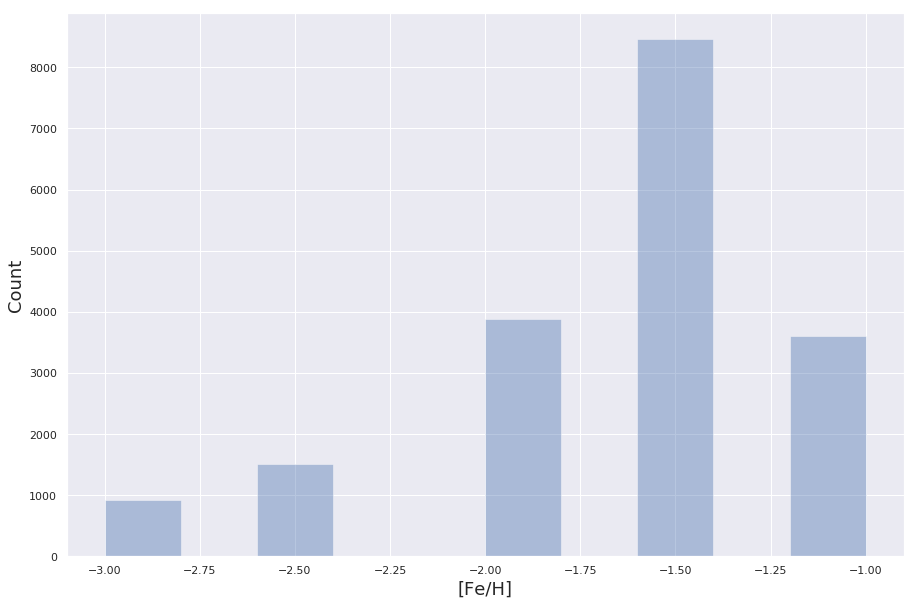

In [8]:
# We will plot the histogram using seaborn.
f, ax = plt.subplots(figsize=(15, 10))
sns.distplot(df['[Fe/H]'],bins=10, kde=False)
ax.set_ylabel('Count',fontsize=18)
ax.set_xlabel('[Fe/H]',fontsize=18)

In [9]:
# We will use a stratified split to ensure that both the test and train sets are
# representative of the income categories.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df["[Fe/H]"]):
    strat_train_set = df.loc[train_index]
    strat_test_set  = df.loc[test_index]

In [10]:
train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)

In [11]:
# Calculates the proportion of each income class in the original data set and in the test sets
# created by a random and a stratified splitting.
def income_cat_proportions(data):
    return data["[Fe/H]"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [12]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
-3.0,0.049821,0.049855,0.051668,3.708030,0.069152
-2.5,0.082073,0.082125,0.076686,-6.564024,0.062641
-2.0,0.211465,0.211385,0.217186,2.705467,-0.037918
-1.5,0.460731,0.460660,0.461385,0.141964,-0.015430
-1.0,0.195910,0.195975,0.193075,-1.447216,0.033389


# 3. Exploratory Analysis

We will start the analysis trying to identify whether the star is normal or carbon stars. At this moment, we will ignore the subclasses of carbon enhanced stars.

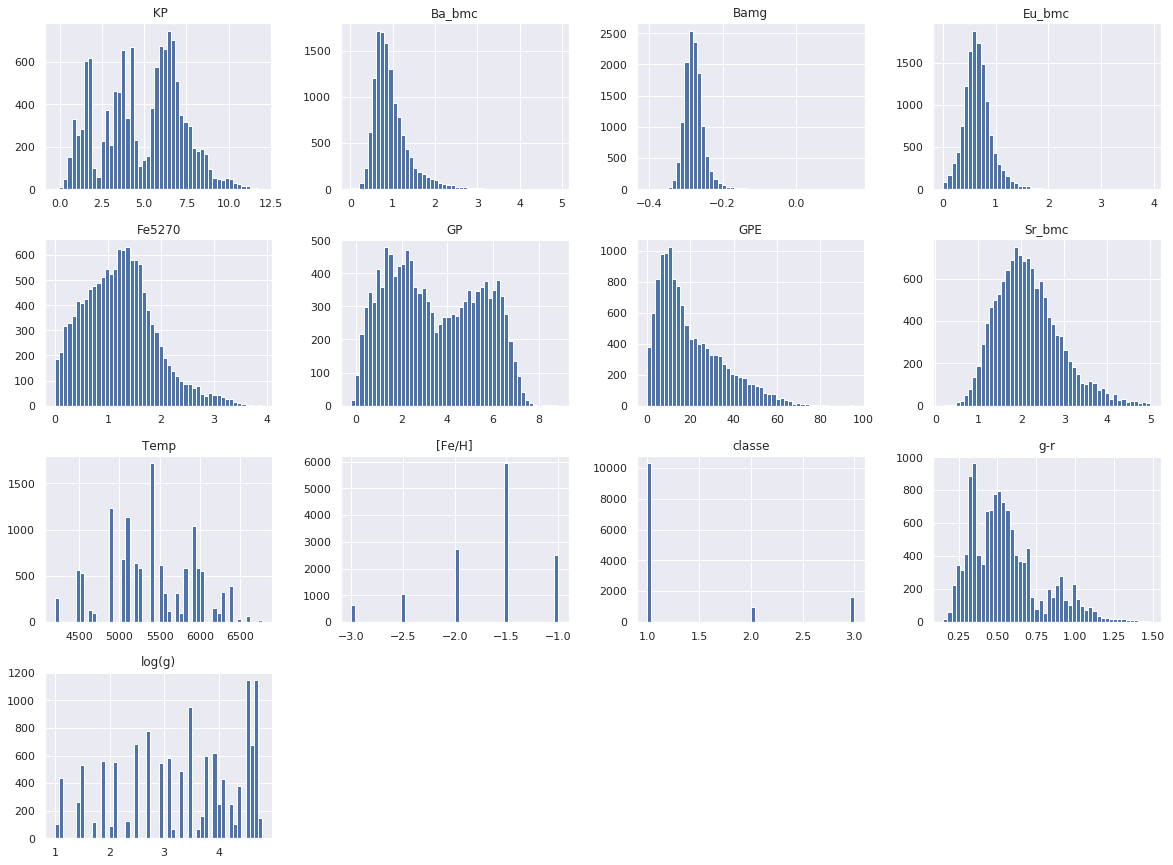

In [13]:
strat_train_set.hist(bins=50, figsize=(20,15))
plt.show()

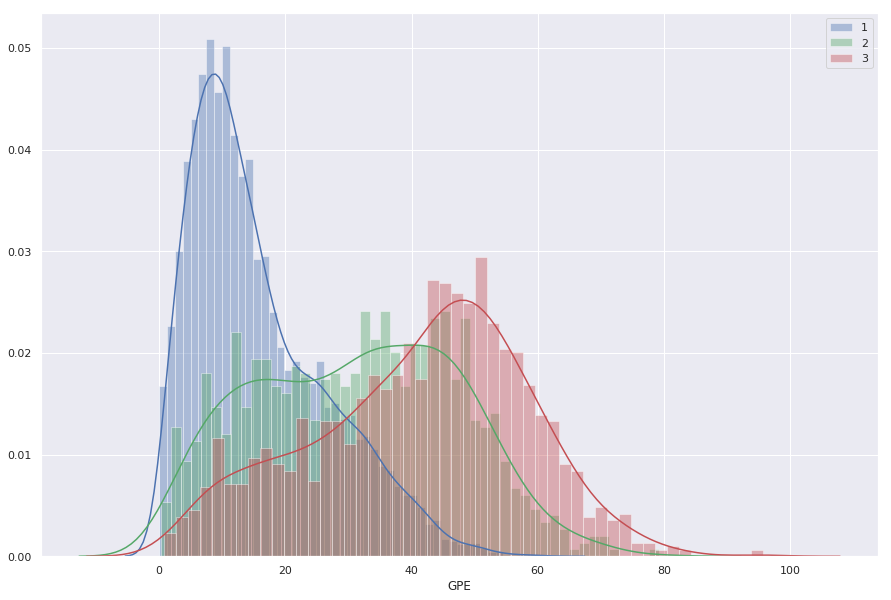

In [14]:
f,axes=plt.subplots(figsize=(15, 10))
sns.distplot(strat_train_set.GPE[strat_train_set.classe==1],bins=50, kde=True,label='1')
sns.distplot(strat_train_set.GPE[strat_train_set.classe==2],bins=50, kde=True,color='g',label='2')
sns.distplot(strat_train_set.GPE[strat_train_set.classe==3],bins=50, kde=True,color='r',label='3')
plt.legend()

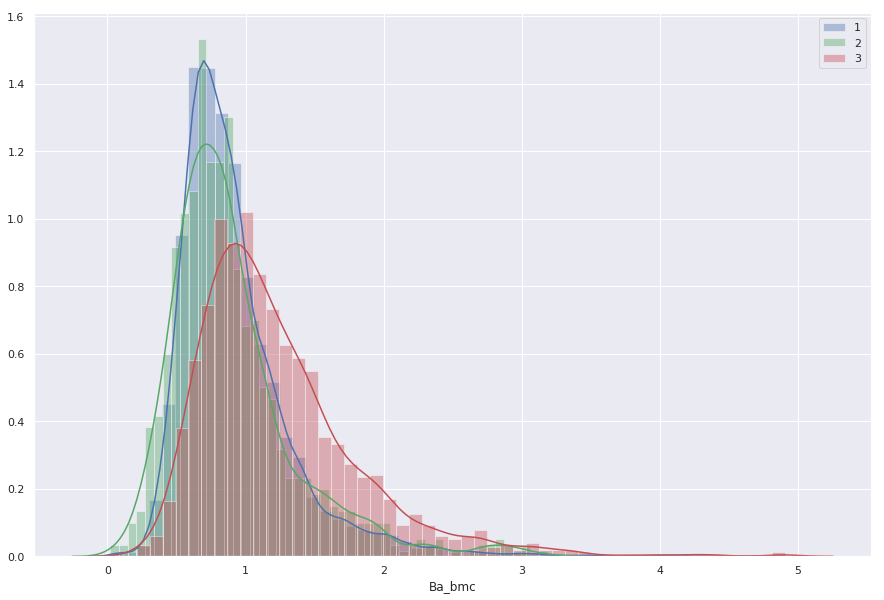

In [15]:
f,axes=plt.subplots(figsize=(15, 10))
sns.distplot(strat_train_set.Ba_bmc[strat_train_set.classe==1],bins=50, kde=True,label='1')
sns.distplot(strat_train_set.Ba_bmc[strat_train_set.classe==2],bins=50, kde=True,color='g',label='2')
sns.distplot(strat_train_set.Ba_bmc[strat_train_set.classe==3],bins=50, kde=True,color='r',label='3')

plt.legend()

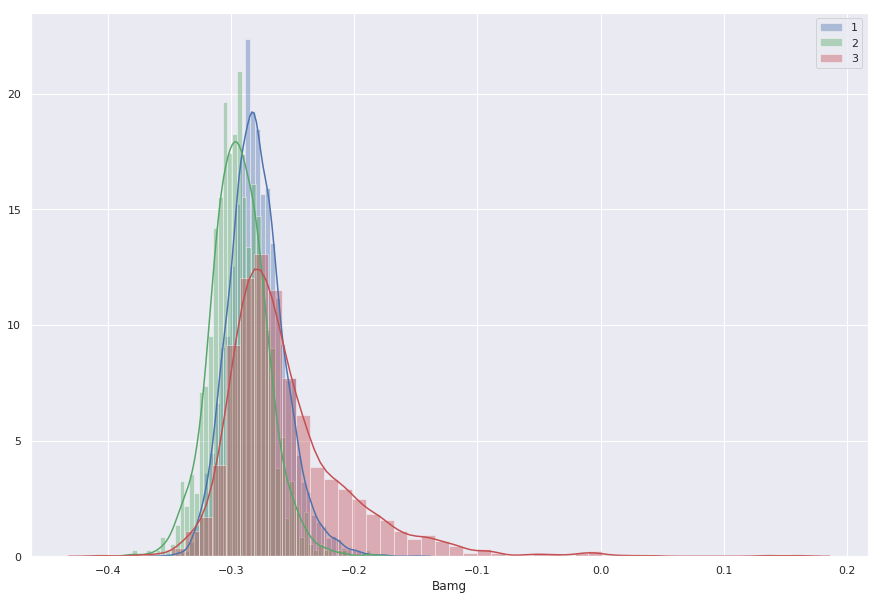

In [16]:
f,axes=plt.subplots(figsize=(15, 10))
sns.distplot(strat_train_set.Bamg[strat_train_set.classe==1],bins=50, kde=True,label='1')
sns.distplot(strat_train_set.Bamg[strat_train_set.classe==2],bins=50, kde=True,color='g',label='2')
sns.distplot(strat_train_set.Bamg[strat_train_set.classe==3],bins=50, kde=True,color='r',label='3')
plt.legend()

## 3.1 Feature Scaling

We have seen above that the features have quite different scales. We will scale the features to have a mean value equal to zero and a standard deviation equal to 1.

In [17]:
std_sc=StandardScaler()

In [18]:
strat_train_set.columns

Index(['ID', 'Temp', '[Fe/H]', 'log(g)', ' KP', 'Fe5270', 'GP', 'GPE', 'g-r',
       'Bamg', 'Ba_bmc', 'Eu_bmc', 'Sr_bmc', 'classe'],
      dtype='object')

In [19]:
strat_train_set[[' KP', 'Fe5270','GP','GPE','g-r',
          'Bamg','Ba_bmc','Eu_bmc','Sr_bmc']] = std_sc.fit_transform(strat_train_set[[' KP','Fe5270','GP','GPE','g-r',
                                                                                      'Bamg','Ba_bmc','Eu_bmc','Sr_bmc']])



In [20]:
strat_train_set.describe()

,Temp,[Fe/H],log(g),KP,Fe5270,GP,GPE,g-r,Bamg,Ba_bmc,Eu_bmc,Sr_bmc,classe
count,12870.000000,12870.000000,12870.000000,1.287000e+04,1.287000e+04,1.287000e+04,1.287000e+04,1.287000e+04,1.287000e+04,1.287000e+04,1.287000e+04,1.287000e+04,12870.000000
mean,5393.006216,-1.664569,3.332098,1.351073e-16,1.083826e-16,4.358941e-17,-4.601344e-17,-3.051517e-16,2.548855e-15,-2.015999e-16,-9.408860e-17,-1.099267e-16,1.326651
std,537.546752,0.518553,1.100943,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,0.687847
min,4200.000000,-3.000000,1.000000,-2.173033e+00,-1.829353e+00,-1.829892e+00,-1.326067e+00,-1.737792e+00,-4.355577e+00,-2.064650e+00,-2.269160e+00,-2.636948e+00,1.000000
25%,5040.000000,-2.000000,2.500000,-7.443028e-01,-7.512520e-01,-8.674073e-01,-7.665386e-01,-8.093181e-01,-5.890337e-01,-6.409211e-01,-5.904485e-01,-7.096935e-01,1.000000
50%,5400.000000,-1.500000,3.500000,1.891566e-01,-2.802604e-02,-1.283005e-01,-3.075614e-01,-1.685404e-01,-1.139742e-01,-2.328877e-01,-9.894932e-02,-1.112108e-01,1.000000
75%,5900.000000,-1.500000,4.400000,7.445686e-01,5.945023e-01,9.037856e-01,5.799540e-01,4.678782e-01,4.289510e-01,3.681938e-01,4.444688e-01,5.702366e-01,1.000000
max,6775.000000,-1.000000,4.800000,3.004201e+00,4.025333e+00,2.713548e+00,4.981650e+00,4.077157e+00,1.485040e+01,8.664873e+00,1.134398e+01,3.806192e+00,3.000000


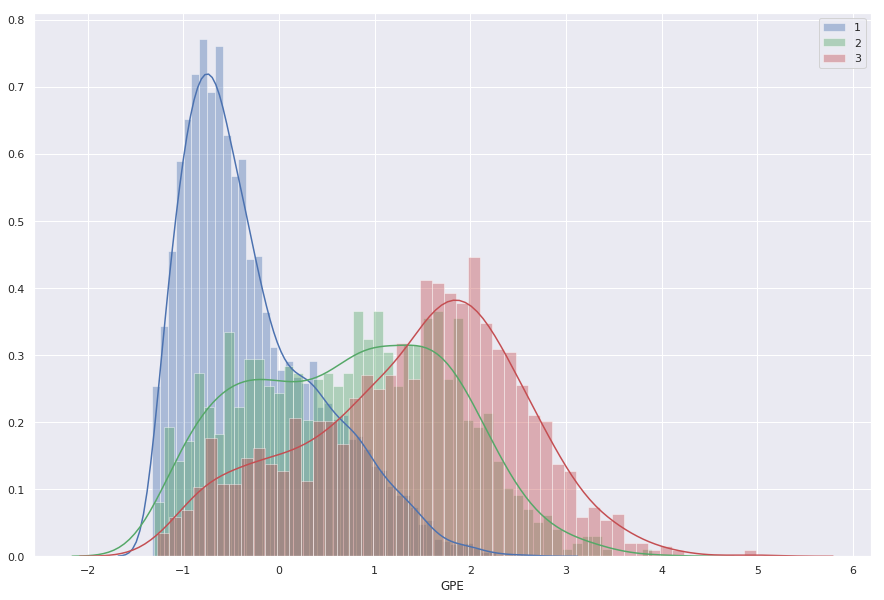

In [21]:
f,axes=plt.subplots(figsize=(15, 10))
sns.distplot(strat_train_set.GPE[strat_train_set.classe==1],bins=50, kde=True,label='1')
sns.distplot(strat_train_set.GPE[strat_train_set.classe==2],bins=50, kde=True,color='g',label='2')
sns.distplot(strat_train_set.GPE[strat_train_set.classe==3],bins=50, kde=True,color='r',label='3')
plt.legend()

In [22]:
# drop non-feature columns
drop_elements = ['ID','Temp','[Fe/H]','log(g)']
train = strat_train_set.drop(drop_elements, axis = 1)
train.head(10)

,KP,Fe5270,GP,GPE,g-r,Bamg,Ba_bmc,Eu_bmc,Sr_bmc,classe
13669,-0.592050,-1.580791,-1.069553,-0.598827,-0.268798,-0.147907,-0.101264,-0.766973,0.301605,1
18119,-1.423058,-1.682611,-0.064981,0.149256,-1.240862,-0.317571,1.870897,1.226714,-1.041887,3
4509,1.283521,0.466103,-0.286600,-0.786738,0.428647,0.734346,0.344063,0.929045,1.590233,1
14074,-1.686414,-1.507420,-1.630887,-0.915354,-1.428301,-1.030160,1.171098,-1.988798,1.291828,1
5671,0.660582,0.262462,0.646612,0.184081,0.123515,-0.113974,-0.430323,0.036040,1.291828,1
6220,0.785507,-0.340975,-0.458468,-0.733643,-0.151104,0.496817,-0.480779,-0.645829,-0.137305,1
12464,-0.856250,-0.993825,-1.318811,-1.039550,-0.918294,-0.046109,0.526142,-0.368928,-1.119499,1
7941,0.167210,0.217541,0.767724,0.539259,-0.255721,-0.113974,0.030360,0.029117,-0.842504,1
6182,0.739504,0.075292,-0.531838,-0.456162,-0.155463,0.157488,-0.156107,0.184874,0.815451,1
1341,1.501296,1.632549,0.177745,0.264153,0.210695,0.089623,-1.132316,0.312941,-1.124851,1


In [23]:
# setting feature matrix and target vector
drop_elem=['classe']
X_train= train.drop(drop_elem, axis = 1)
y_train=train.loc[:,'classe']

In [24]:
X_train.columns

Index([' KP', 'Fe5270', 'GP', 'GPE', 'g-r', 'Bamg', 'Ba_bmc', 'Eu_bmc',
       'Sr_bmc'],
      dtype='object')

# 4. Pre-processing Test Set

In [25]:
strat_test_set[[' KP', 'Fe5270','GP','GPE','g-r',
          'Bamg','Ba_bmc','Eu_bmc','Sr_bmc']] = std_sc.fit_transform(strat_test_set[[' KP','Fe5270','GP','GPE','g-r',
                                                                                      'Bamg','Ba_bmc','Eu_bmc','Sr_bmc']])

In [26]:
drop_elements = ['ID','Temp','[Fe/H]','log(g)']
test = strat_test_set.drop(drop_elements, axis = 1)
test.head(10)

,KP,Fe5270,GP,GPE,g-r,Bamg,Ba_bmc,Eu_bmc,Sr_bmc,classe
13133,-1.377601,-1.354952,-1.437932,-0.750110,-1.359791,-0.869902,2.366824,3.427104,2.943313,1
7822,0.432609,-0.331289,-0.109974,-0.294608,-0.313227,-0.938931,0.086863,0.509367,-0.595715,1
1083,1.056790,0.854885,1.507730,0.724081,0.332526,-0.352188,-0.868488,-0.115130,-1.359140,1
18019,-0.967558,-1.046638,0.389502,0.446494,-0.789747,-0.421217,-0.649509,-0.838593,-1.098425,3
8599,0.009845,-0.909947,-1.036364,-0.963475,-0.754120,-0.076074,-1.035943,-0.719153,0.142307,1
190,1.435455,2.931069,1.764674,0.286003,2.630514,0.717754,-0.336068,1.700350,1.211904,1
12231,-1.012930,-0.759587,-1.286847,-1.210086,-0.927805,-0.593788,3.107490,4.447458,0.547417,1
5305,0.639539,-0.097395,0.872079,0.622205,0.198922,0.061983,-0.960803,-0.237983,-0.651869,1
3419,1.413829,0.654405,0.353221,0.089529,1.396904,1.339011,-1.033796,-0.548525,-0.764176,1
12175,-0.901409,-1.007149,-1.324121,-0.729481,-0.945619,-0.731845,0.653633,1.382982,0.726574,1


In [27]:
# setting feature matrix and target vector
drop_elem=['classe']
X_test= test.drop(drop_elem, axis = 1)
y_test=test.loc[:,'classe']

# 5. Modelling

Because our dataset is extremely imbalanced, we need to balance the data before applying the models. Otherwise, the performace of the models in the minority classes will be poor. We will use two ways to increase the minority classes: Random Oversampling and Synthetic Minority Oversampling Technique (SMOTE).

We will test two models:

Logistic regression and Random Forest



## 5.1 Re-sampling

In [28]:
# Re-sampling:
ros = RandomOverSampler(random_state=42)
smt=SMOTE(random_state=42,k_neighbors=15)

In [29]:
# New training set
X_res1, y_res1 = ros.fit_sample(X_train, y_train)
X_res2, y_res2 = smt.fit_sample(X_train, y_train)

In [30]:
# Proportion of class 0 and class 1 in the training set
pd.value_counts(y_res1,dropna=True,sort=False,normalize=True)

1    0.333333
2    0.333333
3    0.333333
dtype: float64

In [31]:
# we can see that the trainig set is now larger
len(y_res1)

30885

## 5.2 Logistic Regression 

In [32]:
# Logistic Regression
clf_log1 = LogisticRegression(random_state=42)
clf_log1 = clf_log1.fit(X_res1,y_res1) # fit logistic regression to the trainig set
score_log1 = cross_val_score(clf_log1, X_res1, y_res1, cv=5).mean()
print('Accuracy:',score_log1)

Accuracy: 0.7783713776914359


In [33]:
# Logistic Regression
clf_log2 = LogisticRegression(random_state=42)
clf_log2 = clf_log2.fit(X_res2,y_res2) # fit logistic regression to the trainig set
score_log2 = cross_val_score(clf_log2, X_res2, y_res2, cv=5).mean()
print('Accuracy:',score_log2)

Accuracy: 0.8002266472397604


In [34]:
#From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Model Evaluation:**

In [35]:
# Predictions using logistic regression
y_pred_log1 = clf_log1.predict(X_test) 
y_pred_log2 = clf_log2.predict(X_test) 

In [36]:
accuracy_score(y_test, y_pred_log1)

0.9026468455402465

In [37]:
accuracy_score(y_test, y_pred_log2)

0.902102973168963

In [38]:
# Getting confusion matrix for logistic regression
conf_log1=confusion_matrix(y_test, y_pred_log1)
conf_log2=confusion_matrix(y_test, y_pred_log2)

Normalized confusion matrix
[[0.95 0.03 0.02]
 [0.1  0.71 0.19]
 [0.05 0.23 0.72]]


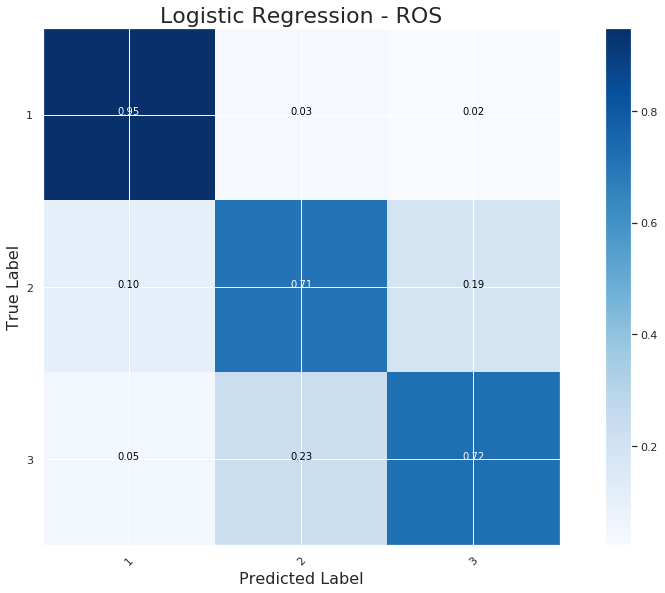

In [39]:
class_names=[1,2,3]
np.set_printoptions(precision=2)

f,ax=plt.subplots(figsize=(13,8))
plot_confusion_matrix(conf_log1, classes=class_names, normalize=True)
ax.set_title('Logistic Regression - ROS',fontsize=22)
ax.set_xlabel('Predicted Label',fontsize=16)
ax.set_ylabel('True Label',fontsize=16)
savefig('conf_matrix_log1.eps', fmt='eps', dpi=200)
savefig('conf_matrix_log1.jpeg', fmt='jpeg', dpi=200)
plt.show()

Normalized confusion matrix
[[0.95 0.03 0.02]
 [0.1  0.7  0.19]
 [0.05 0.23 0.72]]


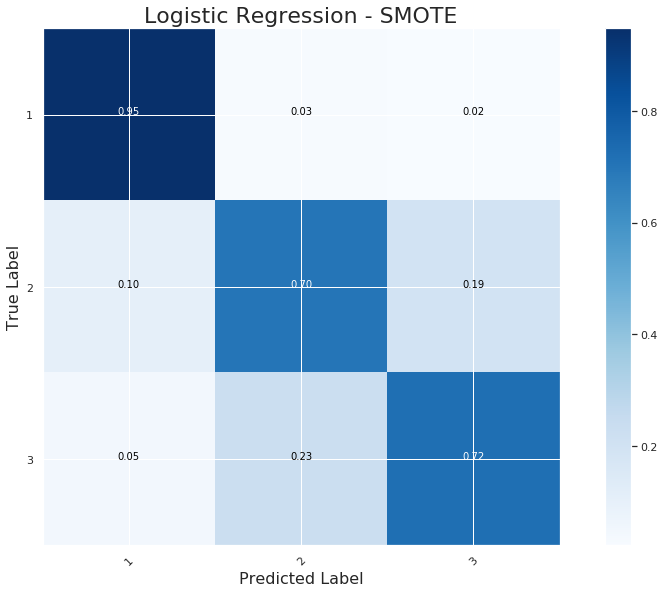

In [40]:
class_names=[1,2,3]
np.set_printoptions(precision=2)

f,ax=plt.subplots(figsize=(13,8))
plot_confusion_matrix(conf_log2, classes=class_names, normalize=True)
ax.set_title('Logistic Regression - SMOTE',fontsize=22)
ax.set_xlabel('Predicted Label',fontsize=16)
ax.set_ylabel('True Label',fontsize=16)
savefig('conf_matrix_log2.eps', fmt='eps', dpi=200)
savefig('conf_matrix_log2.jpeg', fmt='jpeg', dpi=200)
plt.show()

## 5.3 Random Forest

In [41]:
clf_rf1 = RandomForestClassifier(
    max_depth=None, random_state=42
    )
clf_rf1 = clf_rf1.fit(X_res1,y_res1)
score_rf1 = cross_val_score(clf_rf1, X_res1, y_res1, cv=5).mean()
print(score_rf1)

0.9952727861421401


In [42]:
clf_rf2 = RandomForestClassifier(
    max_depth=None, \
    random_state=42)
clf_rf2 = clf_rf2.fit(X_res2,y_res2)
score_rf2 = cross_val_score(clf_rf2, X_res2, y_res2, cv=5).mean()
print(score_rf2)

0.9454751497490692


**Model Evaluation:**

In [44]:
# Predictions using lRandom Forest
y_pred_rf1 = clf_rf1.predict(X_test) 
y_pred_rf2 = clf_rf2.predict(X_test)

In [45]:
accuracy_score(y_test, y_pred_rf1)

0.9309282088469906

In [46]:
accuracy_score(y_test, y_pred_rf2)

0.9193255982596084

In [47]:
# Getting confusion matrix for lRandom Forest
conf_rf1=confusion_matrix(y_test, y_pred_rf1)
conf_rf2=confusion_matrix(y_test, y_pred_rf2)

Normalized confusion matrix
[[0.99 0.01 0.01]
 [0.18 0.6  0.22]
 [0.09 0.14 0.77]]


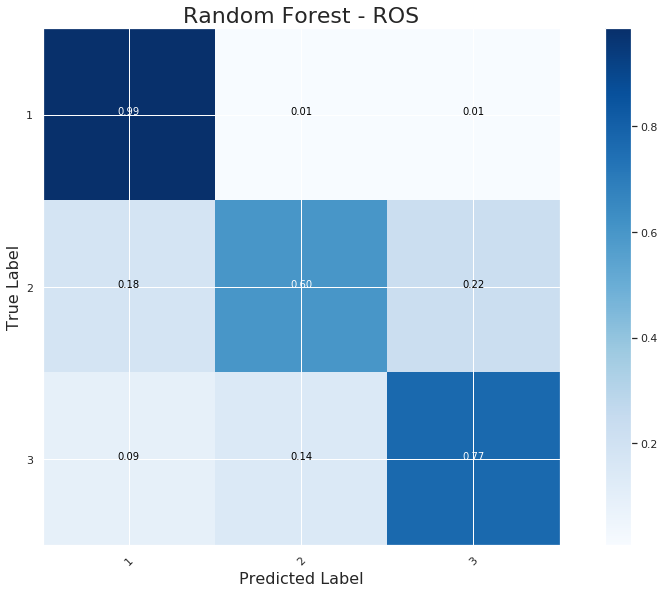

In [48]:
class_names=[1,2,3]
np.set_printoptions(precision=2)

f,ax=plt.subplots(figsize=(13,8))
plot_confusion_matrix(conf_rf1, classes=class_names, normalize=True)
ax.set_title('Random Forest - ROS',fontsize=22)
ax.set_xlabel('Predicted Label',fontsize=16)
ax.set_ylabel('True Label',fontsize=16)
savefig('conf_matrix_rf1.eps', fmt='eps', dpi=200)
savefig('conf_matrix_rf1.jpeg', fmt='jpeg', dpi=200)
plt.show()

Normalized confusion matrix
[[0.97 0.02 0.01]
 [0.12 0.68 0.2 ]
 [0.05 0.21 0.74]]


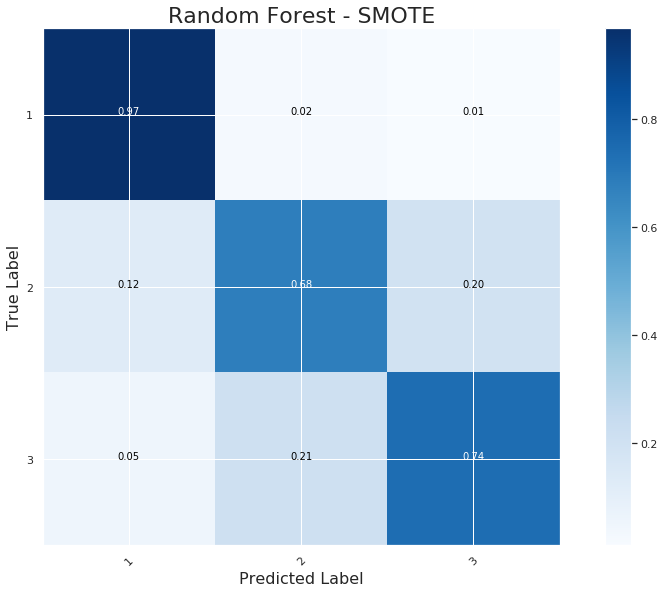

In [49]:
class_names=[1,2,3]
np.set_printoptions(precision=2)

f,ax=plt.subplots(figsize=(13,8))
plot_confusion_matrix(conf_rf2, classes=class_names, normalize=True)
ax.set_title('Random Forest - SMOTE',fontsize=22)
ax.set_xlabel('Predicted Label',fontsize=16)
ax.set_ylabel('True Label',fontsize=16)
savefig('conf_matrix_rf2.eps', fmt='eps', dpi=200)
savefig('conf_matrix_rf2.jpeg', fmt='jpeg', dpi=200)
plt.show()

## 5.4 Grid Search:

In [50]:
C_vals = [0.001,0.05,0.01,0.1,1,10]
penalty_vals=['l1','l2']

clf_logr = LogisticRegression(random_state=42)

param_grid = [{'C':C_vals, 'penalty':penalty_vals}]
grid_search_lr = GridSearchCV(clf_logr, param_grid, cv=5,scoring='accuracy')
grid_search_lr.fit(X_res1, np.ravel(y_res1))



GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.001, 0.05, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [51]:
grid_search_lr.best_params_

{'C': 0.01, 'penalty': 'l1'}

In [52]:
# Shows mean error for each parameter combination
cvres = grid_search_lr.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.8660861556886839 {'C': 0.001, 'penalty': 'l1'}
0.8725668081639398 {'C': 0.001, 'penalty': 'l2'}
0.8825287815975553 {'C': 0.05, 'penalty': 'l1'}
0.8825104374289047 {'C': 0.05, 'penalty': 'l2'}
0.8831522566181659 {'C': 0.01, 'penalty': 'l1'}
0.8808027598162113 {'C': 0.01, 'penalty': 'l2'}
0.8822719285280161 {'C': 0.1, 'penalty': 'l1'}
0.8828038983855332 {'C': 0.1, 'penalty': 'l2'}
0.882216878855318 {'C': 1, 'penalty': 'l1'}
0.8822535790187739 {'C': 1, 'penalty': 'l2'}
0.8823086264016474 {'C': 10, 'penalty': 'l1'}
0.8823086264016474 {'C': 10, 'penalty': 'l2'}


In [53]:
final_model1 = grid_search_lr.best_estimator_  
y_pred_gs = final_model1.predict(X_test)

In [54]:
conf_gs=confusion_matrix(y_test, y_pred_gs)

In [55]:
accuracy_score(y_test, y_pred_gs)

0.9017403915881074

Normalized confusion matrix
[[0.95 0.03 0.02]
 [0.1  0.72 0.18]
 [0.05 0.24 0.71]]


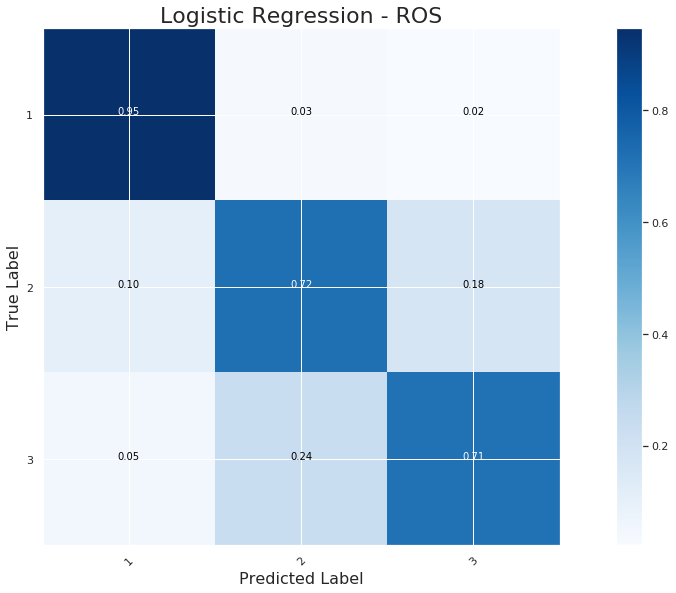

In [56]:
class_names=[1,2,3]
np.set_printoptions(precision=2)

f,ax=plt.subplots(figsize=(16,8))
plot_confusion_matrix(conf_gs, classes=class_names, normalize=True)
ax.set_title('Logistic Regression - ROS',fontsize=22)
ax.set_xlabel('Predicted Label',fontsize=16)
ax.set_ylabel('True Label',fontsize=16)
#savefig('conf_matrix_log.eps', fmt='eps', dpi=200)
savefig('conf_matrix_log_gs.eps', fmt='eps', dpi=200)
savefig('conf_matrix_log_gs.jpeg', fmt='jpeg', dpi=200)
plt.show()

In [57]:
n_vals = [200,400,600]
penalty_vals=['gini','entropy']
min_samples_vals=[2,5,10]
clf_rfg = RandomForestClassifier(random_state=42)


param_grid = [{'n_estimators':n_vals, 'criterion':penalty_vals, 'min_samples_split': min_samples_vals}]


grid_search_rf = GridSearchCV(clf_rfg, param_grid, cv=5,scoring='accuracy')

grid_search_rf.fit(X_res1, np.ravel(y_res1))


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [200, 400, 600], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [58]:
grid_search_rf.best_params_

{'criterion': 'entropy', 'min_samples_split': 5, 'n_estimators': 400}

In [59]:
# Shows mean error for each parameter combination
cvres = grid_search_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.9980716391742995 {'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 200}
0.9981689566334574 {'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 400}
0.9981527377158349 {'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 600}
0.9980067555961927 {'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 200}
0.997990534042548 {'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 400}
0.9980554186752179 {'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 600}
0.9975524523836313 {'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 200}
0.9975849094742835 {'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 400}
0.9975686810609612 {'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 600}
0.9983959938152024 {'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 200}
0.9984122087812 {'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 400}
0.9984284234838585 {'criterion': 'entropy', 'min_

In [60]:
final_model = grid_search_rf.best_estimator_  
y_pred_gsr = final_model.predict(X_test)

In [61]:
conf_gsr=confusion_matrix(y_test, y_pred_gsr)

In [62]:
accuracy_score(y_test, y_pred_gsr)

0.9403553299492385

Normalized confusion matrix
[[0.99 0.   0.01]
 [0.16 0.62 0.22]
 [0.08 0.12 0.8 ]]


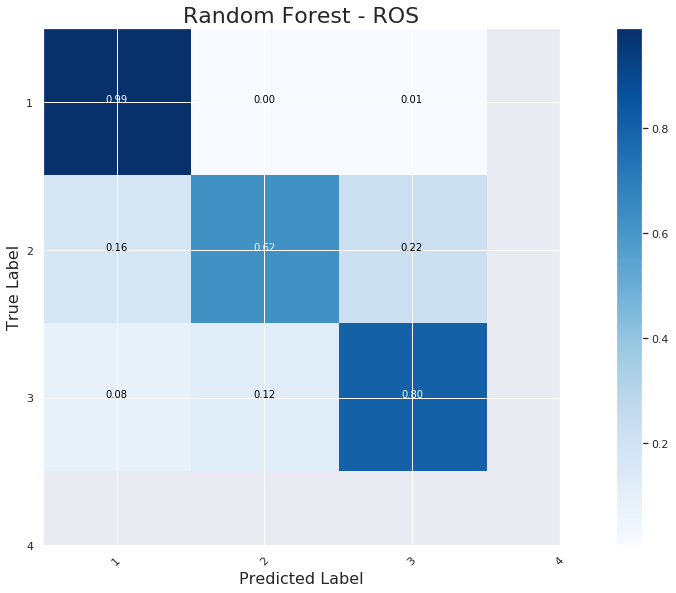

In [63]:
class_names=[1,2,3,4]
np.set_printoptions(precision=2)

f,ax=plt.subplots(figsize=(16,8))
plot_confusion_matrix(conf_gsr, classes=class_names, normalize=True)
ax.set_title('Random Forest - ROS',fontsize=22)
ax.set_xlabel('Predicted Label',fontsize=16)
ax.set_ylabel('True Label',fontsize=16)
savefig('conf_matrix_rf_gs.eps', fmt='eps', dpi=200)
savefig('conf_matrix_rf_gs.jpeg', fmt='jpeg', dpi=200)
#savefig('conf_matrix_log.eps', fmt='eps', dpi=200)
plt.show()

# 6. Applying to Observed Stars

In this section we will apply the best model got from grid search for the logistic regression using Random Oversampling.

In [64]:
# Getting the data into a dataframe
dfo = pd.read_csv('Hugo_obs.csv')
dfo.head(10)

,ID,temp,[Fe/H],log(g),KP,Fe5270,GP,GPE,g-r,Bamg,Ba_bmc,Eu_bmc,Sr_bmc,CN1,CN2,Dz,l,b,Vr
0,spec-0266-51630-0056.fits2.txt,6267,-2.056,3.953,3.228,0.232,0.818,7.125,0.313,-0.370,1.260,1.919,2.581,-0.248,-0.214,1.290,237.133,37.418,299.3
1,spec-0273-51957-0147.fits2.txt,6043,-1.503,4.205,5.875,1.161,1.927,19.030,0.339,-0.395,0.748,0.471,1.841,-0.221,-0.569,1.098,246.990,47.117,31.2
2,spec-0280-51612-0258.fits2.txt,6117,-1.246,4.057,6.278,1.042,2.230,14.491,0.316,-0.542,0.786,0.359,1.649,-0.228,-0.259,2.157,260.968,54.720,113.8
3,spec-0280-51612-0280.fits2.txt,6053,-1.149,3.998,7.076,1.040,2.886,5.318,0.341,0.043,0.582,0.538,1.376,-0.299,-2.573,2.452,259.662,54.776,246.4
4,spec-0281-51614-0317.fits2.txt,6234,-1.338,3.740,6.068,0.897,1.378,2.803,0.296,-0.124,0.543,0.282,1.404,-0.226,1.765,-9999.000,261.108,55.302,399.2
5,spec-0282-51630-0271.fits2.txt,6420,-1.969,3.492,1.807,0.591,0.698,1.123,0.235,-0.359,1.471,0.277,2.943,-0.248,0.818,5.461,264.933,56.576,62.6
6,spec-0282-51658-0214.fits2.txt,6244,-1.207,3.579,6.314,1.419,1.913,7.329,0.243,0.031,0.910,0.928,2.632,-0.252,0.063,6.248,265.804,56.147,331.9
7,spec-0282-51658-0483.fits2.txt,6025,-1.040,3.858,7.303,1.338,2.978,17.071,0.306,0.019,1.074,0.791,2.504,-0.205,-1.371,3.822,265.525,57.580,263.8
8,spec-0283-51584-0443.fits2.txt,6297,-1.463,2.328,3.914,1.250,1.363,7.010,0.132,0.069,3.221,0.679,3.153,-0.225,-1.730,13.431,267.696,59.308,184.8
9,spec-0284-51943-0510.fits2.txt,5900,-2.160,4.324,4.353,0.533,1.335,10.879,0.326,-0.553,0.369,0.832,1.795,-0.191,-2.025,1.334,273.572,60.018,48.9


In [65]:
dfo[[' KP', 'Fe5270','GP','GPE','g-r',
          'Bamg','Ba_bmc','Eu_bmc','Sr_bmc']] = std_sc.fit_transform(dfo[[' KP','Fe5270','GP','GPE','g-r',
                                                                      'Bamg','Ba_bmc','Eu_bmc','Sr_bmc']])
                                                                  

In [66]:
dfo.describe()

,temp,[Fe/H],log(g),KP,Fe5270,GP,GPE,g-r,Bamg,Ba_bmc,Eu_bmc,Sr_bmc,CN1,CN2,Dz,l,b,Vr
count,17036.000000,17036.000000,17036.000000,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,17036.000000,55.000000,17036.000000,17036.000000,17036.000000,17036.000000
mean,5556.779584,-1.504155,3.442723,1.042252e-15,-3.295608e-16,-1.404514e-15,-1.298849e-15,1.134590e-15,1.430057e-17,-7.099536e-17,-8.559979e-17,-5.128102e-16,-0.217109,-0.427691,-4324.152203,151.898993,51.877479,-43.961816
std,525.957407,0.370186,0.918218,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,0.148711,1.122344,4957.177404,88.525071,15.586280,141.089011
min,4015.000000,-4.282000,1.001000,-4.557218e+00,-1.959948e+00,-2.400189e+00,-1.761120e+00,-2.858177e+00,-2.656180e+00,-2.223234e+00,-2.449006e+00,-2.690338e+00,-9.990000,-3.017000,-9999.000000,0.134000,-7.015000,-718.000000
25%,5160.000000,-1.701000,2.665750,-6.624004e-01,-6.931044e-01,-9.377641e-01,-7.784559e-01,-8.860526e-01,-2.704200e-01,-6.402413e-01,-6.059597e-01,-6.466864e-01,-0.252000,-1.008000,-9999.000000,72.511750,39.658250,-136.900000
50%,5435.000000,-1.419500,3.730500,2.056599e-01,-1.308868e-01,1.577804e-01,-1.083274e-01,5.738469e-02,5.747595e-01,-2.073721e-01,-1.875571e-01,-2.190408e-01,-0.226000,-0.299000,-3.491000,150.455000,51.471000,-45.100000
75%,6081.000000,-1.230750,4.219000,8.446419e-01,5.322036e-01,9.068270e-01,5.889157e-01,6.314037e-01,6.924427e-01,3.815313e-01,3.795340e-01,3.703424e-01,-0.198000,0.318500,3.535250,214.147000,63.239500,41.300000
max,6512.000000,-1.000000,4.898000,2.049983e+00,5.426018e+00,2.461608e+00,6.444944e+00,4.655221e+00,1.730195e+00,8.487762e+00,6.887250e+00,4.982609e+00,1.641000,1.765000,148.802000,359.993000,89.817000,928.800000


In [67]:
drop_elements = ['ID','temp','[Fe/H]','log(g)','CN1','CN2','Dz','l','b','Vr']
X_new = dfo.drop(drop_elements, axis = 1)
X_new.describe()

,KP,Fe5270,GP,GPE,g-r,Bamg,Ba_bmc,Eu_bmc,Sr_bmc
count,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04,1.703600e+04
mean,1.042252e-15,-3.295608e-16,-1.404514e-15,-1.298849e-15,1.134590e-15,1.430057e-17,-7.099536e-17,-8.559979e-17,-5.128102e-16
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00
min,-4.557218e+00,-1.959948e+00,-2.400189e+00,-1.761120e+00,-2.858177e+00,-2.656180e+00,-2.223234e+00,-2.449006e+00,-2.690338e+00
25%,-6.624004e-01,-6.931044e-01,-9.377641e-01,-7.784559e-01,-8.860526e-01,-2.704200e-01,-6.402413e-01,-6.059597e-01,-6.466864e-01
50%,2.056599e-01,-1.308868e-01,1.577804e-01,-1.083274e-01,5.738469e-02,5.747595e-01,-2.073721e-01,-1.875571e-01,-2.190408e-01
75%,8.446419e-01,5.322036e-01,9.068270e-01,5.889157e-01,6.314037e-01,6.924427e-01,3.815313e-01,3.795340e-01,3.703424e-01
max,2.049983e+00,5.426018e+00,2.461608e+00,6.444944e+00,4.655221e+00,1.730195e+00,8.487762e+00,6.887250e+00,4.982609e+00


In [68]:
y_pred_new = final_model1.predict(X_new)

In [69]:
yy=pd.Series(y_pred_new)
pd.value_counts(yy,dropna=True,sort=False,normalize=True)

1    0.831592
2    0.033517
3    0.134891
dtype: float64

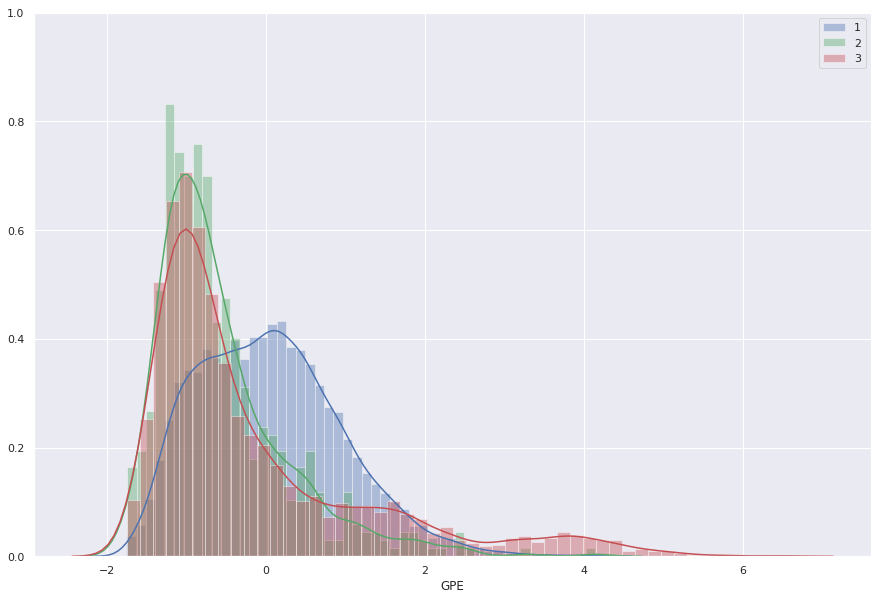

In [70]:
f,axes=plt.subplots(figsize=(15, 10))
sns.distplot(X_new.GPE[yy==1],bins=50, kde=True,label='1')
sns.distplot(X_new.GPE[yy==2],bins=50, kde=True,color='g',label='2')
sns.distplot(X_new.GPE[yy==3],bins=50, kde=True,color='r',label='3')
ylim(0,1)
plt.legend()
plt.show()

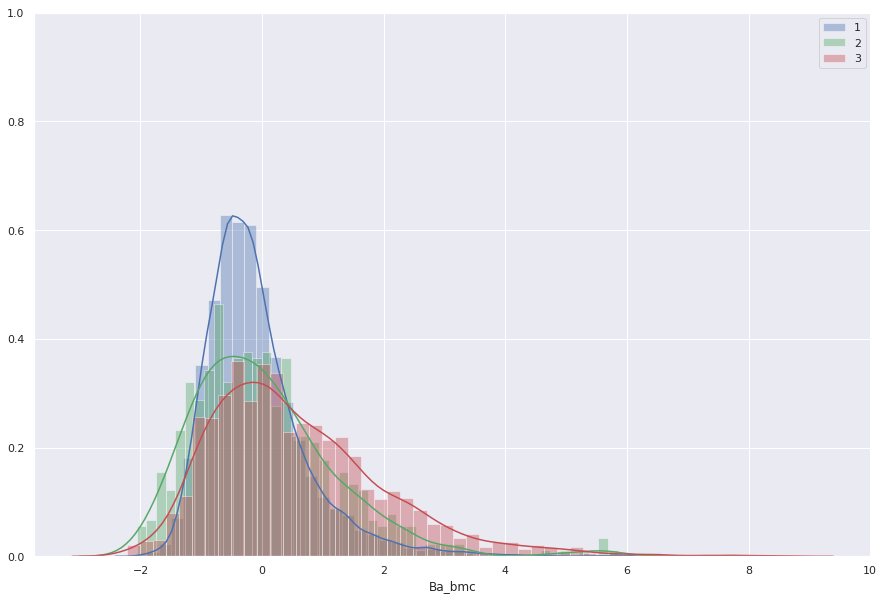

In [71]:
f,axes=plt.subplots(figsize=(15, 10))
sns.distplot(X_new.Ba_bmc[yy==1],bins=50, kde=True,label='1')
sns.distplot(X_new.Ba_bmc[yy==2],bins=50, kde=True,color='g',label='2')
sns.distplot(X_new.Ba_bmc[yy==3],bins=50, kde=True,color='r',label='3')
ylim(0,1)

plt.legend()
plt.show()

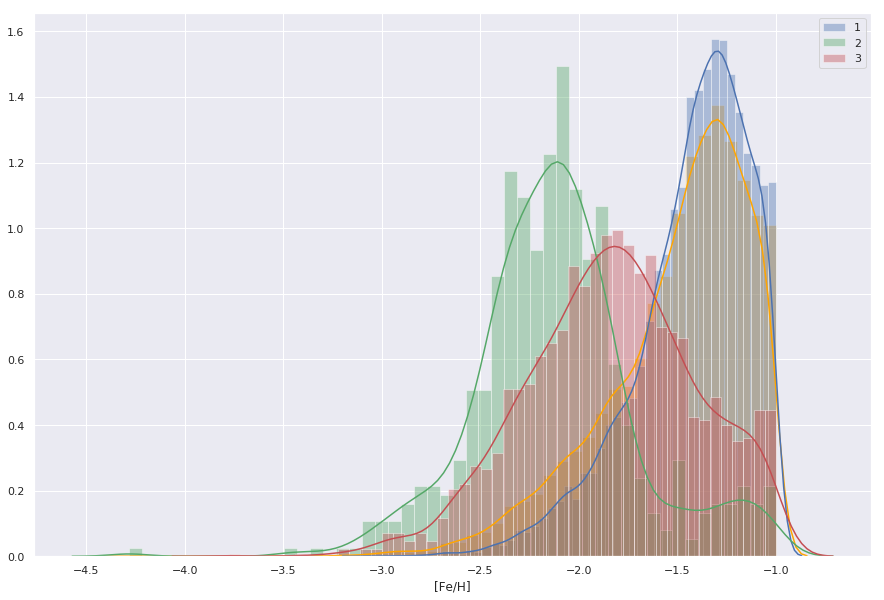

In [72]:
f,axes=plt.subplots(figsize=(15, 10))
sns.distplot(dfo['[Fe/H]'],bins=50, kde=True,color='orange')
sns.distplot(dfo['[Fe/H]'][yy==1],bins=50, kde=True,label='1')
sns.distplot(dfo['[Fe/H]'][yy==2],bins=50, kde=True,color='g',label='2')
sns.distplot(dfo['[Fe/H]'][yy==3],bins=50, kde=True,color='r',label='3')

plt.legend()
savefig('SDSS_lr1.eps', fmt='eps', dpi=200)
savefig('SDSS_lr1.jpeg', fmt='jpeg', dpi=200)
plt.show()

The Figure above shows the distribution of **[Fe/H]** for each class in our observed sample. Class 1 appears to be predominant at higher values of **[Fe/H]** and Class 2 is predominant at the lowest end of **[Fe/H]**. This result is quite encoreging, since it is quite similar to what we observe in nature. 

# 7. Conclusions

In this project we use synthetic data and machine learning models to find ways to select Carbon stars from the SDSS database. This database possesses spectra for hundreds of thousands of stars that can be potential targets for observations in high resolution in large telescopes. 

We used 9 features related to key chemical elements and a synthetic sample of approximately 20,000 objects. 

Before applying the models, we resampled our dataset to balance the data, using two types of oversampling.

We applied logistic regression and random forest. We get similar results with both techniques, however, random forest tends to increase the performance on carbon normal stars which is not what we want. 

Overall, the models increase our chance to correctly find Carbon rich stars from 7% and 13% to around 70%, which is a significant improvement. 

Finally, we applied the best logistic regression model to a set of observed stars from the SDSS database. We see that the distribution of metallicities ([Fe/H]) for each class resembles what we know from high-resolution studies which is an indication that the model performace on an unknown sample is doing fine. 